In [1]:
import os
import shutil
from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import dask
import util

In [2]:
#import plotting modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.colorbar import Colorbar 
from matplotlib import ticker, cm
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
from matplotlib.ticker import FormatStrFormatter


## Spin up dask cluster

In [3]:
from ncar_jobqueue import NCARCluster
cluster = NCARCluster(project='UCUC0006')
cluster.scale(32)
cluster

/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/distributed/node.py:244: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38434 instead
  http_address["port"], self.http_server.port


In [4]:
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client

Client Scheduler: tcp://10.12.205.11:33561 Dashboard: https://jupyterhub.ucar.edu/dav/user/zephyrs/proxy/38434/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


# Load Data

In [5]:
ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr')
ds_djf = ds_djf[['SST', 'Chl_surf', 'KGP']]
ds_djf['KGP'] = ds_djf['KGP'].sel(length = 40)
ds_djf

<xarray.Dataset>
Dimensions:    (length: 3, member_id: 34, nlat: 93, nlon: 320, time: 180)
Coordinates:
  * length     (length) float64 20.0 40.0 60.0
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    SST        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    Chl_surf   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    KGP        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>

## Compute the properties of the unperturbed climate

The mean

In [6]:
%%time
ds_ctrl_mean = (
        ds_djf.sel(time=slice(1920, 1950))
        .mean(dim=['time', 'member_id'])
        .compute()
)
    
ds_ctrl_mean

CPU times: user 535 ms, sys: 70.7 ms, total: 605 ms
Wall time: 4.98 s


<xarray.Dataset>
Dimensions:   (length: 3, nlat: 93, nlon: 320)
Coordinates:
  * length    (length) float64 20.0 40.0 60.0
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08 -30.08
    ULAT      (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82 -29.82
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
    ULONG     (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 317.8 318.9 320.0
Dimensions without coordinates: nlat, nlon
Data variables:
    SST       (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 23.14 23.04 22.99 22.96
    Chl_surf  (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.1035 0.1016 0.09941
    KGP       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

Standard deviation of anomalies

In [7]:
%%time
ds_ctrl_std = ( #data - mean of ref time
        (ds_djf - ds_djf.mean(dim=['member_id']).sel(time=slice(1920, 1950)))
        .std(dim=['time', 'member_id']) #take it's standard deviation
        .compute() #compute it
)
ds_ctrl_std

CPU times: user 586 ms, sys: 31.9 ms, total: 618 ms
Wall time: 3.12 s


<xarray.Dataset>
Dimensions:   (length: 3, nlat: 93, nlon: 320)
Coordinates:
  * length    (length) float64 20.0 40.0 60.0
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08 -30.08
    ULAT      (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82 -29.82
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
    ULONG     (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 317.8 318.9 320.0
Dimensions without coordinates: nlat, nlon
Data variables:
    SST       (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.4305 0.4294 0.4313
    Chl_surf  (nlat, nlon) float64 0.0 0.0 0.0 ... 0.002909 0.003036 0.003102
    KGP       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

## Compute the properties of the current climate: 2000-2030

The mean

In [8]:
%%time
ds_curr_mean = (
        ds_djf.sel(time=slice(2070, 2100))
        .mean(dim=['time', 'member_id'])
        .compute()
)
    
ds_curr_mean

CPU times: user 316 ms, sys: 20 ms, total: 336 ms
Wall time: 878 ms


<xarray.Dataset>
Dimensions:   (length: 3, nlat: 93, nlon: 320)
Coordinates:
  * length    (length) float64 20.0 40.0 60.0
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08 -30.08
    ULAT      (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82 -29.82
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
    ULONG     (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 317.8 318.9 320.0
Dimensions without coordinates: nlat, nlon
Data variables:
    SST       (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 25.84 25.71 25.66 25.62
    Chl_surf  (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.07553 0.07499 0.07447
    KGP       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

Make Polar Plottable

In [93]:
v = 'KGP'
dssa = ds_ctrl_std
dso = ds_ctrl_mean
dsm = ds_curr_mean

# Polar Plottable
dsp= util.pop_add_cyclic(
    xr.Dataset({
        f'dso_{v}_mean': dso[v],
        f'dsm_{v}_mean': dsm[v],
        f'{v}_mean_bias': dsm[v]-dso[v],
        
        f'dssa_{v}_std': dssa[v],

        'TLAT': dsm.TLAT.compute(),
        'TLONG': dsm.TLONG.compute() } ))
dsp

<xarray.Dataset>
Dimensions:        (nlat: 93, nlon: 321)
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT           (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08
    TLONG          (nlat, nlon) float64 -220.6 -219.4 -218.3 ... 138.3 139.4
    dso_KGP_mean   (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dsm_KGP_mean   (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    KGP_mean_bias  (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dssa_KGP_std   (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [94]:
# Control - Current 
levels = np.linspace(-0.05, 0.22, 21)
labels = [-0.04, 0, 0.04, 0.9, 0.13, 0.17,0.2]

# Std of Anomolies
levels_a = np.linspace(-.05,.1,11)

cmap = cmocean.cm.curl_r
extent = ([-180, 180, -90, -50], ccrs.PlateCarree())
prj = ccrs.SouthPolarStereo()
fmt = '%.2f'

In [95]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [96]:
def epoch_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels, #extend = 'both',
                     norm=MidpointNormalize(midpoint=0.),
                     cmap=cmap,
                     transform=ccrs.PlateCarree())
    # contour lines
    cs = ax.contour(dsp.TLONG, dsp.TLAT, da,
                    colors='k',
                    levels=levels,#_cont,
                    linewidths=0.05,
                    transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

In [97]:
def std_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels_a,
                     norm=MidpointNormalize(midpoint=0.),
                     cmap=cmap,
                     transform=ccrs.PlateCarree())
#    cs = ax.contour(dsp.TLONG, dsp.TLAT, da,
#                    colors='k', 
#                    #levels=levels_chng,
#                    linewidths=.05,
#                    transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
   
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

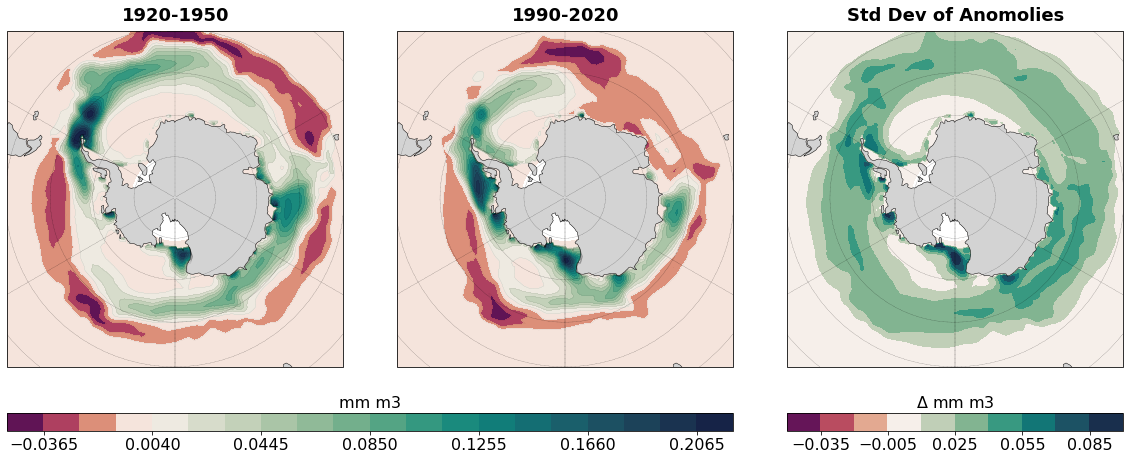

In [16]:
# Observations -- CESM-LE -- CESM-LE Bias
dsp = dsp
#v = 'KGP'
vp1 = 'dso_KGP_mean'
vp2 = 'dsm_KGP_mean'
vp3 = 'dssa_KGP_std'
unit = 'mm m3'
pt = 'KGP-MEAN_STD'
########################################################
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2,3, height_ratios=[2,0.1])
t1, t2, t3 = '1920-1950', '1990-2020', 'Std Dev of Anomolies'
########################################################

ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp1],lines = False)
ax.set_title(f'{t1}', fontsize = 18, fontweight = 'bold',pad=10)
# --------------------------------------------------------
ax = fig.add_subplot(gs[0, 1], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp2],lines = False)
ax.set_title(f'{t2}', fontsize = 18, fontweight = 'bold',pad=10)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cbax = plt.subplot(gs[1,:2]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}', labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(labelsize=16)
#cb.ax.set_xticklabels(labels)
########################################################
ax = fig.add_subplot(gs[0, 2], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = std_plot(dsp[vp3], lines=False)
ax.set_title(f'{t3}', fontsize = 18, fontweight = 'bold',pad=10)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cbax = plt.subplot(gs[1,2:]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'$\Delta$ {unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('top')
#cb.ax.set_xticklabels(cb_labels)

cb.ax.tick_params(labelsize=16)

########################################################
ax = fig.get_axes()
gs.update(hspace=0.16, wspace= 0.16, bottom=0.4)

# --------------------------------------------------------
title = (f'{pt}-ctrl-v-future')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')

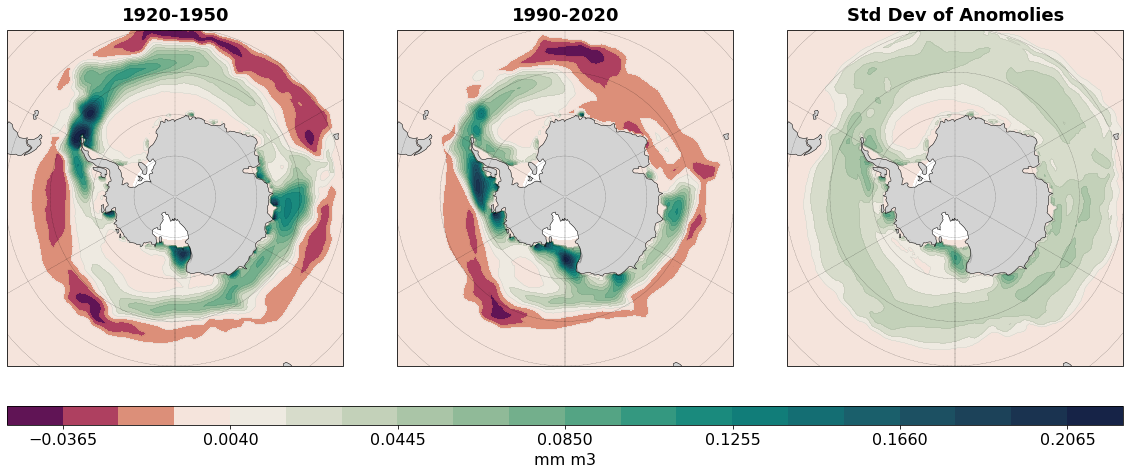

In [98]:
# Observations -- CESM-LE -- CESM-LE Bias
dsp = dsp
#v = 'KGP'
vp1 = 'dso_KGP_mean'
vp2 = 'dsm_KGP_mean'
vp3 = 'dssa_KGP_std'
unit = 'mm m3'
pt = 'KGP-MEAN_STD'
########################################################
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2,3, height_ratios=[2,0.1])
t1, t2, t3 = '1920-1950', '1990-2020', 'Std Dev of Anomolies'
########################################################

ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp1],lines = False)
ax.set_title(f'{t1}', fontsize = 18, fontweight = 'bold',pad=10)
# --------------------------------------------------------
ax = fig.add_subplot(gs[0, 1], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp2],lines = False)
ax.set_title(f'{t2}', fontsize = 18, fontweight = 'bold',pad=10)

########################################################
ax = fig.add_subplot(gs[0, 2], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp3], lines=False)
ax.set_title(f'{t3}', fontsize = 18, fontweight = 'bold',pad=10)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cbax = plt.subplot(gs[1,:3]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16)

########################################################
ax = fig.get_axes()
gs.update(hspace=0.1, wspace= 0.16, bottom=0.4)
# --------------------------------------------------------
title = (f'{pt}-ctrl-v-future')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')

# Repeat for SST

In [86]:
v = 'SST'
dssa = ds_ctrl_std
dso = ds_ctrl_mean
dsm = ds_curr_mean

# Polar Plottable
dsp= util.pop_add_cyclic(
    xr.Dataset({
        f'dso_{v}_mean': dso[v],
        f'dsm_{v}_mean': dsm[v],
        f'{v}_mean_bias': dsm[v]-dso[v],
        
        f'dssa_{v}_std': dssa[v],

        'TLAT': dsm.TLAT.compute(),
        'TLONG': dsm.TLONG.compute() } ))
dsp

<xarray.Dataset>
Dimensions:        (nlat: 93, nlon: 321)
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT           (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08
    TLONG          (nlat, nlon) float64 -220.6 -219.4 -218.3 ... 138.3 139.4
    dso_SST_mean   (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dsm_SST_mean   (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SST_mean_bias  (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dssa_SST_std   (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [87]:
# Control - Current 
levels = np.linspace(-2, 20, 23)
#labels = [-0.04, 0, 0.04, 0.9, 0.13, 0.17,0.2]

# Std of Anomolies
levels_a = np.linspace(-.05,.1,11)

cmap = cmocean.cm.thermal
extent = ([-180, 180, -90, -50], ccrs.PlateCarree())
prj = ccrs.SouthPolarStereo()
fmt = '%.2f'

In [88]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [91]:
def epoch_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels, extend = 'max',
                     #norm=MidpointNormalize(midpoint=0.),
                     cmap=cmap,
                     transform=ccrs.PlateCarree())
    # contour lines
    cs = ax.contour(dsp.TLONG, dsp.TLAT, da,
                    colors='k',
                    levels=levels,#_cont,
                    linewidths=0.05,
                    transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

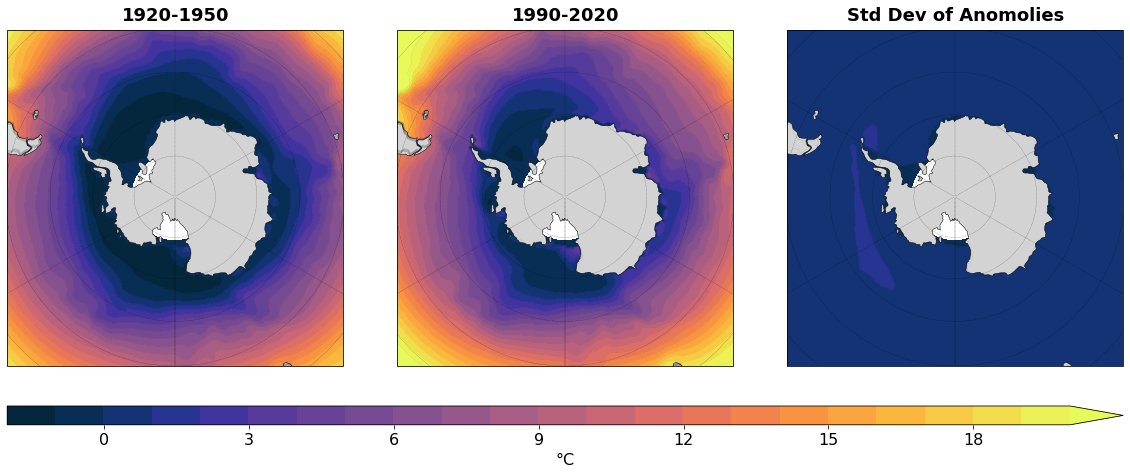

In [92]:
# Observations -- CESM-LE -- CESM-LE Bias
dsp = dsp
vp1 = 'dso_SST_mean'
vp2 = 'dsm_SST_mean'
vp3 = 'dssa_SST_std'
unit = '°C'
pt = 'SST-MEAN_STD'
########################################################
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2,3, height_ratios=[2,0.1])
t1, t2, t3 = '1920-1950', '1990-2020', 'Std Dev of Anomolies'
########################################################

ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp1],lines = False)
ax.set_title(f'{t1}', fontsize = 18, fontweight = 'bold',pad=10)
# --------------------------------------------------------
ax = fig.add_subplot(gs[0, 1], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp2],lines = False)
ax.set_title(f'{t2}', fontsize = 18, fontweight = 'bold',pad=10)

########################################################
ax = fig.add_subplot(gs[0, 2], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp3], lines=False)
ax.set_title(f'{t3}', fontsize = 18, fontweight = 'bold',pad=10)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cbax = plt.subplot(gs[1,:3]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16)

########################################################
ax = fig.get_axes()
gs.update(hspace=0.1, wspace= 0.16, bottom=0.4)
# --------------------------------------------------------
title = (f'{pt}-ctrl-v-future')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')

# Repeat for Chl

In [22]:
v = 'Chl_surf'
dssa = ds_ctrl_std
dso = ds_ctrl_mean
dsm = ds_curr_mean

# Polar Plottable
dsp= util.pop_add_cyclic(
    xr.Dataset({
        f'dso_{v}_mean': dso[v],
        f'dsm_{v}_mean': dsm[v],
        f'{v}_mean_bias': dsm[v]-dso[v],
        
        f'dssa_{v}_std': dssa[v],

        'TLAT': dsm.TLAT.compute(),
        'TLONG': dsm.TLONG.compute() } ))
dsp

<xarray.Dataset>
Dimensions:             (nlat: 93, nlon: 321)
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT                (nlat, nlon) float64 -79.22 -79.22 ... -30.08 -30.08
    TLONG               (nlat, nlon) float64 -220.6 -219.4 ... 138.3 139.4
    dso_Chl_surf_mean   (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dsm_Chl_surf_mean   (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Chl_surf_mean_bias  (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dssa_Chl_surf_std   (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [23]:
levels = np.logspace(-1.65,.815,11)
labels = [0.02,  0.07,  0.2,  0.7,  2.1,  6.5]
labels_diff = [-3.4, -2.6, -1.8, -0.9, -0.08, 0.8, 1.6]

#levels = np.logspace(-1.65,.22,11) #pre july
norm = colors.LogNorm(vmin=levels[0], vmax=levels[-1])
# test number
levels_chng = np.linspace(-4, 1.6, 21) 

#levels_chng = np.linspace(-1, .5, 11) 
cmap = cmocean.cm.dense

In [77]:
# Control - Current 
levels = np.logspace(-2.3,.815,11)
norm = colors.LogNorm(vmin=levels[0], vmax=levels[-1])
labels = labels = [0.005, 0.021, 0.088, 0.37, 1.6, 6.5]
#[0.005,  0.01,  0.021,  0.043,  0.088,  0.18, 0.37, 0.76, 1.6, 3.2, 6.5]
#labels = [0.02,  0.07,  0.2,  0.7,  2.1,  6.5]


cmap = cmocean.cm.dense
extent = ([-180, 180, -90, -50], ccrs.PlateCarree())
prj = ccrs.SouthPolarStereo()
fmt = '%.2f'

In [78]:
np.logspace(-2.3,.815,11)

array([5.01187234e-03, 1.02683343e-02, 2.10377844e-02, 4.31022558e-02,
       8.83079900e-02, 1.80925591e-01, 3.70680722e-01, 7.59451423e-01,
       1.55596563e+00, 3.18786558e+00, 6.53130553e+00])

In [79]:
def epoch_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels, #extend = 'both',
                     norm=norm,
                     cmap=cmap,
                     transform=ccrs.PlateCarree())
    # contour lines
    cs = ax.contour(dsp.TLONG, dsp.TLAT, da,
                    colors='k',
                    levels=levels,#_cont,
                    linewidths=0.05,
                    transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


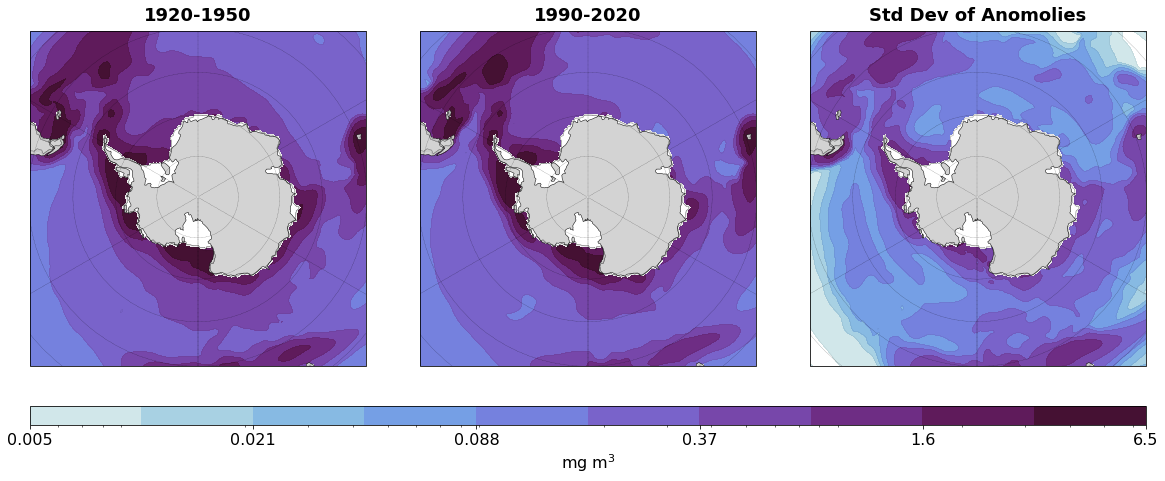

In [85]:
# Observations -- CESM-LE -- CESM-LE Bias
dsp = dsp
vp1 = 'dso_Chl_surf_mean'
vp2 = 'dsm_Chl_surf_mean'
vp3 = 'dssa_Chl_surf_std'
unit = 'mg m$^3$'
pt = 'CHL-MEAN_STD'
########################################################
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2,3, height_ratios=[2,0.1])
t1, t2, t3 = '1920-1950', '1990-2020', 'Std Dev of Anomolies'
########################################################

ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp1],lines = False)
ax.set_title(f'{t1}', fontsize = 18, fontweight = 'bold',pad=10)
# --------------------------------------------------------
ax = fig.add_subplot(gs[0, 1], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp2],lines = False)
ax.set_title(f'{t2}', fontsize = 18, fontweight = 'bold',pad=10)

########################################################
ax = fig.add_subplot(gs[0, 2], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp3], lines=False)
ax.set_title(f'{t3}', fontsize = 18, fontweight = 'bold',pad=10)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cbax = plt.subplot(gs[1,:3]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16)

########################################################
ax = fig.get_axes()
gs.update(hspace=0.1, wspace= 0.16, bottom=0.4)

# --------------------------------------------------------
title = (f'{pt}-ctrl-v-future')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')